<a href="https://colab.research.google.com/github/jiinjung/MineralClassifier/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'mineralClassifier'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

!cd /content/drive/My\ Drive/$FOLDERNAME/data

Mounted at /content/drive


In [ ]:
import torch

USE_GPU = True
dtype = torch.float32 # We will be using float.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


In [ ]:
import numpy as np
from utils.loadData import*
from utils.unet import*
from utils.metrics import*

# **Dataset Preparation**

In [ ]:
# unzip the data
import zipfile as zf

files = zf.ZipFile("/content/drive/MyDrive/mineralClassifier/semdatav5 2.zip", 'r')
files.extractall()
files.close()

In [ ]:
# associated the input and output folder
input_folder = "semdatav5/input-images"  # replace with your folder
output_folder = "semdatav5/output-images"  # replace with your folder

dataset = create_segmentation_dataset(input_folder, output_folder)

# Get a sample from your dataset
input_image, output_image = dataset[0]

# Print the sizes of the images
print('Input image size:', input_image.shape)
print('Output image size:', output_image.shape)

Input image size: torch.Size([1, 256, 256])
Output image size: torch.Size([1, 256, 256])


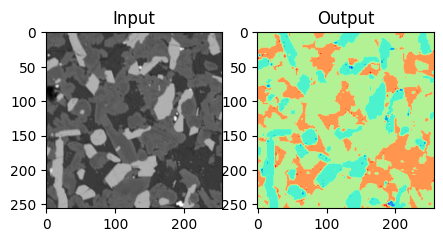

In [ ]:
# Check the image data
import matplotlib.pyplot as plt

# Get the first example from the dataset
input_image, output_image = dataset[2]

# The output of the transforms is a PyTorch tensor, so we need to convert it to a numpy array
input_image_np = input_image.numpy()
output_image_np = output_image.numpy()

# The images are probably in [C, H, W] format, but matplotlib expects [H, W, C]
input_image_np = np.squeeze(np.transpose(input_image_np, (1, 2, 0)))
output_image_np = np.squeeze(np.transpose(output_image_np, (1, 2, 0)))

# Plot the images
plt.figure(figsize=(5, 3))

plt.subplot(1, 2, 1)
plt.imshow(input_image_np, cmap='gray')
plt.title('Input')

plt.subplot(1, 2, 2)
plt.imshow(output_image_np, cmap='rainbow')
plt.title('Output')

plt.show()

In [ ]:
from torch.utils.data import random_split

# Total size of your dataset
dataset_size = len(dataset)

# Decide on a ratio for your training and validation split
train_ratio = 0.80
val_ratio = 0.20

# Calculate the sizes of your training and validation sets
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Create the datasets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create the DataLoaders (adjust batch size)
batch_size = 10
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle = False)

print(f"data size: {dataset_size}")
print(f"train size: {train_size}")
print(f"validation size: {val_size}")

data size: 3256
train size: 2604
validation size: 652


# Model Creation and Training

In [ ]:
# Create the model
in_channels = 1  # grayscale images
out_channels = 10  # 10 classes segmentation
model = UNet(in_channels, out_channels).to(device)

# Load a previous model if you want to keep working on it!
# model = torch.load('/content/drive/MyDrive/mineralClassifier/models/model_150epoch.pth')

In [ ]:
# ious
num_classes = 10
ious_sum_train = np.zeros(num_classes)
ious_sum_val = np.zeros(num_classes)

# Training parameters
num_epochs = 100
learning_rate = 1e-6
weight_decay = 1e-5
counter = 0

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use Cross Entropy Loss for multi-class problems
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

In [ ]:
for epoch in range(num_epochs):

    model.train()
    pa_sum_train = 0 # pixel accuracy
    ious_sum_train = 0 # intersection over union

    for input_images, output_images in loader_train:
        # formatting
        input_images = input_images.to(device)
        output_images = output_images.to(device).long()
        output_images = output_images.squeeze(1)

        # Zero the gradients, Forward pass, Calculate the loss
        optimizer.zero_grad()
        predictions = model(input_images)
        loss = criterion(predictions, output_images)

        # Backward pass, Update the weights, predictions
        loss.backward()
        optimizer.step()
        _, predictions = torch.max(predictions, 1)

        # Calculate training pixel accuracy
        pa_train = pixel_accuracy(predictions, output_images)
        pa_sum_train += pa_train

        # Calcuate training intersection over union
        ious_train = compute_iou(predictions, output_images, num_classes)
        ious_sum_train += np.array(ious_train)

        # Switch to evaluation mode
        model.eval()
        pa_sum_val = 0 # pixel accuracy
        ious_sum_val = 0 # intersection over union

        with torch.no_grad():  # No need to track the gradients
            for input_images, output_images in loader_val:
                input_images = input_images.to(device)
                output_images = output_images.to(device).long()
                output_images = output_images.squeeze(1)  # remove the channel dimension

                # Forward pass
                predictions = model(input_images)

                # Calculate validation pixel accuracy
                _, predicted = torch.max(predictions.data, 1)
                predicted = predicted.to(device)

                # Count the number of images where predictions match the ground truth
                pa_val = pixel_accuracy(predictions, output_images)
                pa_sum_val += pa_val

                # Calcuate validation intersection over union
                ious_val = compute_iou(predicted, output_images, num_classes)
                ious_sum_val += np.array(ious_val)

                # Increment the total number of images
                total_val += output_images.nelement()

        # Calculate the pixel accuracy for this epoch
        pa_avg_train = pa_sum_train / len(loader_train)
        pa_avg_val = pa_sum_val / len(loader_val)

        # compute the average IoU per class
        ious_avg_train = ious_sum_train / len(loader_train)
        ious_avg_val = ious_sum_val / len(loader_val)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, \
        Train Pixel Accuracy: {pa_avg_train:.4f}, Validation Pixel Accuracy: {pa_avg_val:.4f}")

        print("train iou")
        print(ious_avg_train)
        print("val iou")
        print(ious_avg_val)


In [ ]:
# save your model!
torch.save(model, 'sem_model_100epoch.pth')

# Results

In [ ]:
# quick test your model
model = torch.load('/content/drive/MyDrive/mineralClassifier/models/sem_model_100epoch.pth')
model.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Dropout2d(p=0.3, inplace=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Dropout2d(p=0.3, inplace=False

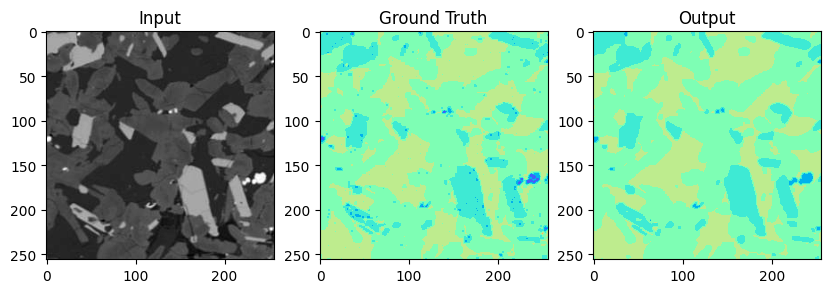

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Get an example from the dataset
input_image, output_image = dataset[10]

# PyTorch tensor to convert it to a numpy array
input_image_np = input_image.numpy()
output_image_np = output_image.numpy()

# [C, H, W] to [H, W, C]
input_image_np = np.squeeze(np.transpose(input_image_np, (1, 2, 0)))
output_image_np = np.squeeze(np.transpose(output_image_np, (1, 2, 0)))

# Move the input to GPU if available
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)


# Output
with torch.no_grad():
    prediction = model(input_image)

_, predicted_class_map = prediction.max(dim=1)
predicted_class_map = predicted_class_map.cpu()
bounds = np.linspace(0, 9, 10)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)
predicted_class_map_np = predicted_class_map.squeeze().numpy()

# Plot the images
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.imshow(input_image_np, cmap='gray')
plt.title('Input')

plt.subplot(1, 3, 2)
plt.imshow(output_image_np, norm=norm, cmap='rainbow')
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(predicted_class_map_np, norm=norm, cmap='rainbow')
plt.title('Output')

plt.show()